### Importing and loading data

In [218]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Extrass
import pickle
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

#modeling
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [42]:
with open('data.pkl', 'rb') as picklefile: 
    df = pickle.load(picklefile)
print(df.columns)
print(df.shape)
#df.drop(['level_0', 'index'], axis=1, inplace=True)

Index(['Bathroom', 'Bedrooms', 'Elevation', 'Landmarks', 'Neighborhood',
       'Pets Allowed?', 'Rent', 'Starbucks_dist', 'Tree_Cover_Pct',
       'Amenities_num'],
      dtype='object')
(1190, 10)


In [24]:
print(df.columns)

Index(['Bathroom', 'Bedrooms', 'Elevation', 'Landmarks', 'Neighborhood',
       'Pets Allowed?', 'Rent', 'Starbucks_dist', 'Tree_Cover_Pct',
       'Amenities_num'],
      dtype='object')


In [8]:
df.isna().sum()

Bathroom          0
Bedrooms          0
Elevation         0
Landmarks         0
Neighborhood      0
Pets Allowed?     0
Rent              0
Starbucks_dist    0
Tree_Cover_Pct    0
Amenities_num     0
dtype: int64

### EDA STEPS AND PLOTS

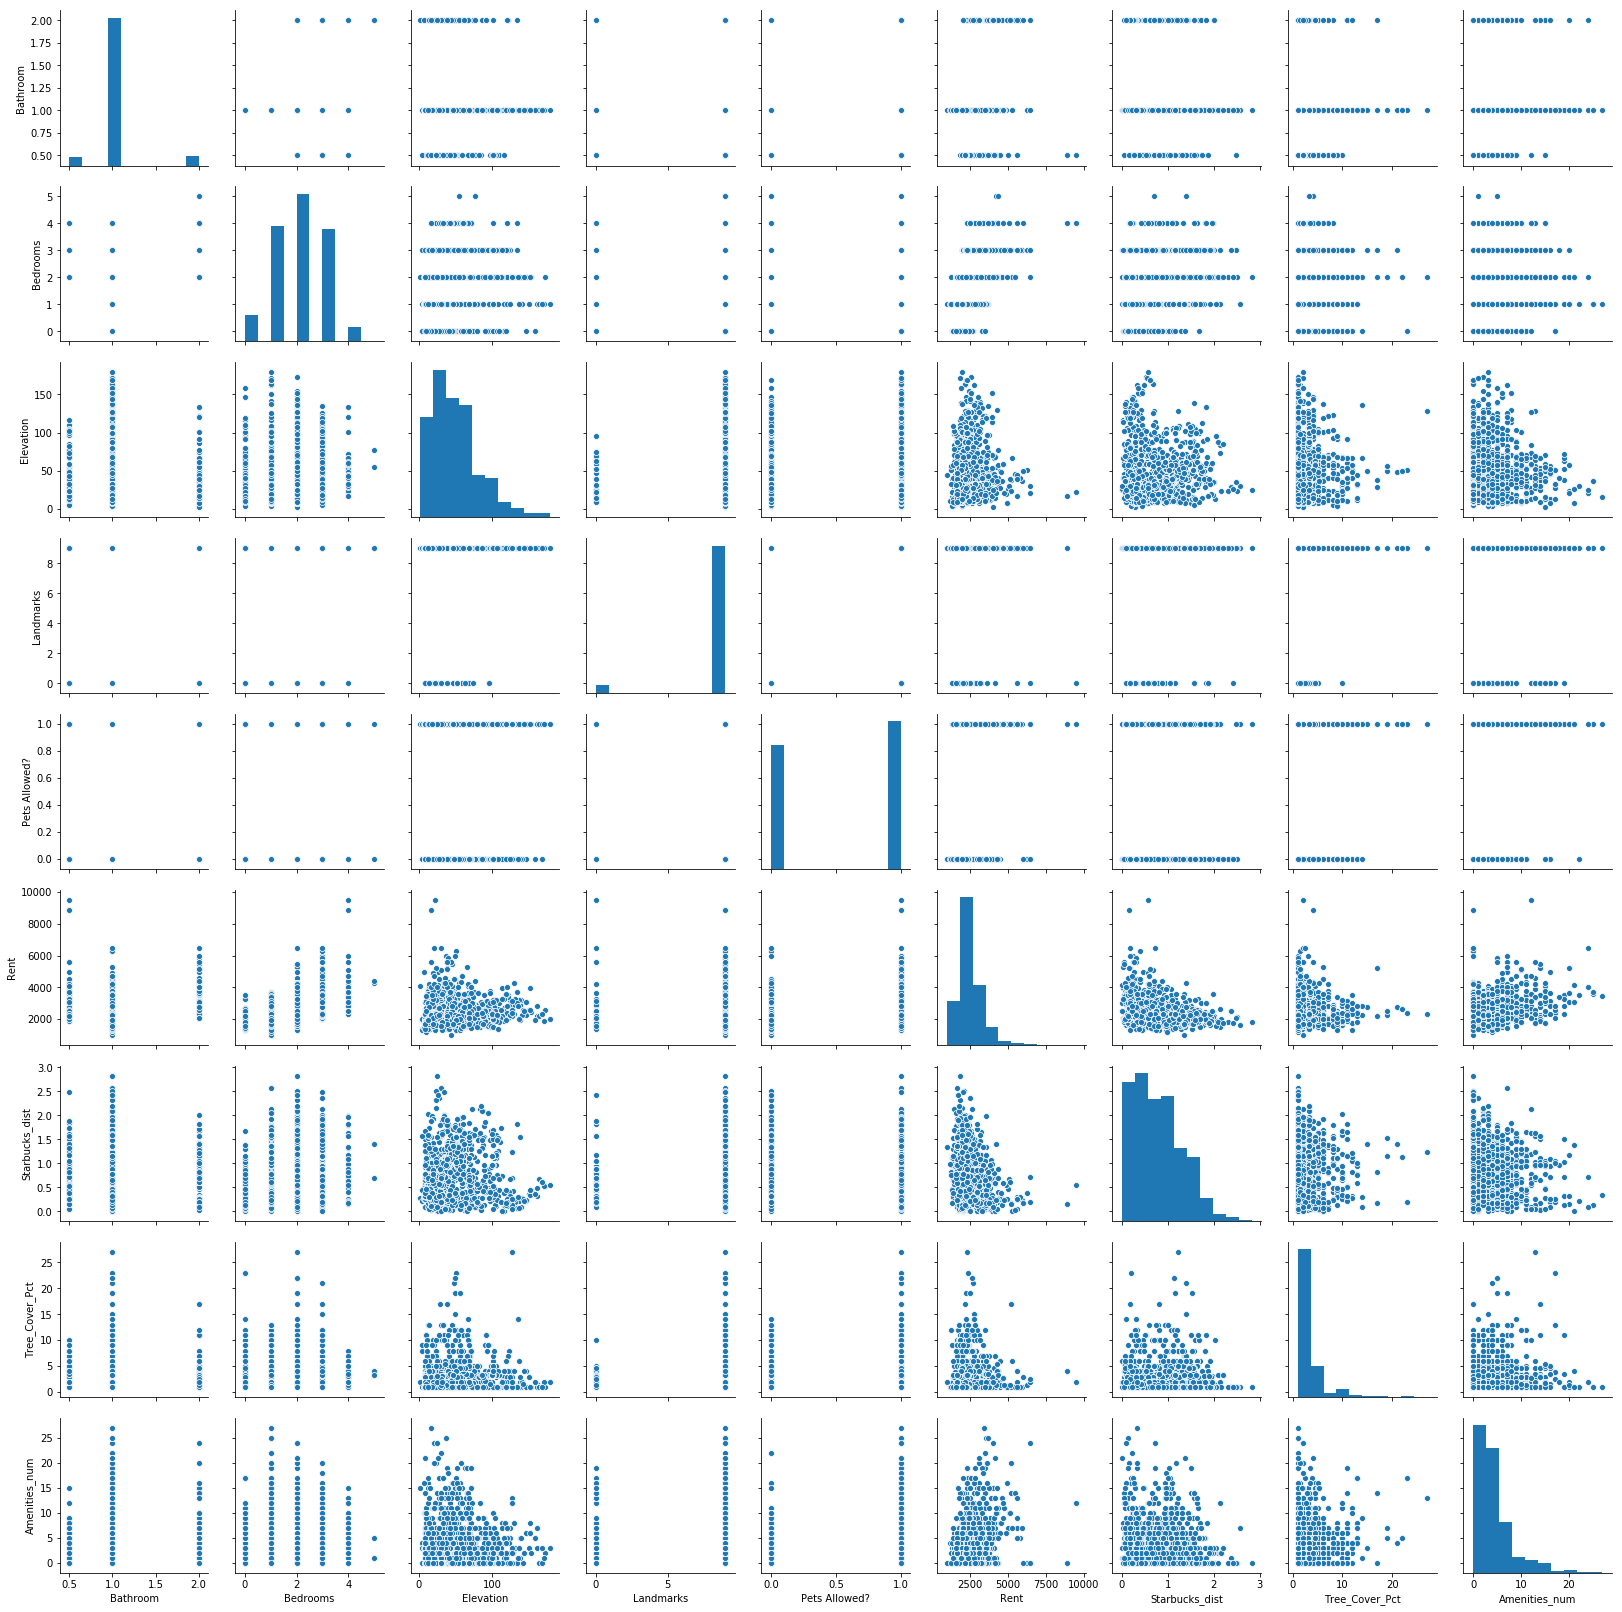

In [9]:
sns.pairplot(df)

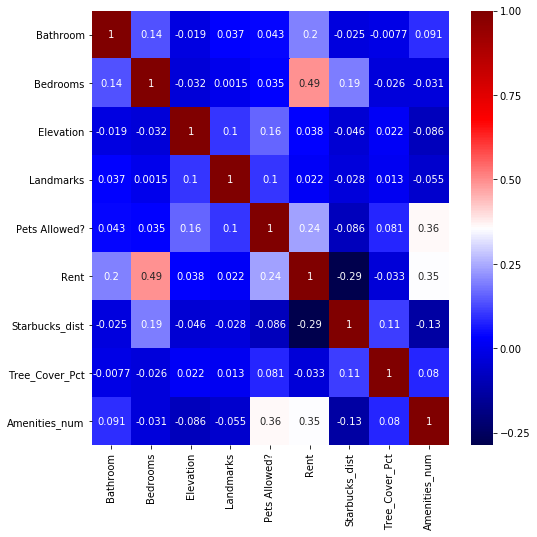

In [13]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, cmap='seismic')

In [14]:
print(df.corr())
print(df.columns)

                Bathroom  Bedrooms  Elevation  Landmarks  Pets Allowed?  \
Bathroom        1.000000  0.139098  -0.019352   0.037249       0.042965   
Bedrooms        0.139098  1.000000  -0.031720   0.001517       0.035379   
Elevation      -0.019352 -0.031720   1.000000   0.101820       0.161797   
Landmarks       0.037249  0.001517   0.101820   1.000000       0.103183   
Pets Allowed?   0.042965  0.035379   0.161797   0.103183       1.000000   
Rent            0.196543  0.494362   0.038149   0.021724       0.237027   
Starbucks_dist -0.024736  0.194218  -0.045965  -0.028415      -0.085922   
Tree_Cover_Pct -0.007686 -0.026396   0.022146   0.013263       0.080616   
Amenities_num   0.091297 -0.030879  -0.086200  -0.054573       0.364343   

                    Rent  Starbucks_dist  Tree_Cover_Pct  Amenities_num  
Bathroom        0.196543       -0.024736       -0.007686       0.091297  
Bedrooms        0.494362        0.194218       -0.026396      -0.030879  
Elevation       0.038149   

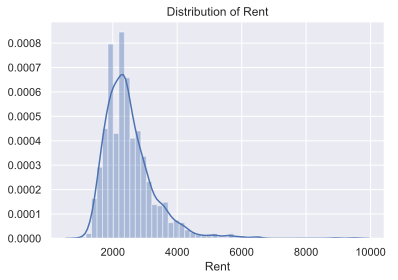

In [231]:
sns.distplot(df["Rent"], kde=True)
plt.title("Distribution of Rent")
plt.savefig("rent_hist.svg", format='svg')

### MODELING START

In [192]:
##Create copy of original df and then get dummies
df2 = df.copy()

#Transforming Neighborhood to get dummy variables
barrio_dums = pd.get_dummies(df2['Neighborhood'], drop_first=True) 
df2 = pd.concat([df2, barrio_dums], axis= 1)  #remerge the data frames
df2.drop(["Neighborhood"], axis=1, inplace=True) #drop original neighborhood column

In [193]:
#creating x and y matrices based on all columns that are NOT 'Rent'
y = df2.loc[:, df2.columns == 'Rent']
X = df2.loc[:, df2.columns != 'Rent']

In [195]:
#Baseline with dummy variable 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)

#BASELINE MODEL with 60/20 split train/val
baseline = LinearRegression()
baseline.fit(X_train,y_train)
print("Baseline Training score", baseline.score(X_train,y_train))
print("Baseline Test Score", baseline.score(X_test,y_test))
print("Seems that the model is over fitting the training set..")
print("\n")
for feature, coef in zip(X.columns, baseline.coef_[0]): #need 0 as it returned a a nest array
    print(feature, ':', f'{coef:.2f}') 

Baseline Training score 0.7728071550495677
Baseline Validation Score 0.6202703272788307
Seems that the model is over fitting the training set..


Bathroom : 113.01
Bedrooms : 487.42
Elevation : 1.14
Landmarks : -4.47
Pets Allowed? : -8.67
Starbucks_dist : -332.64
Tree_Cover_Pct : 13.01
Amenities_num : 40.55
Bay Ridge : 208.53
Bedford Stuyvesant : 780.13
Bensonhurst : 160.65
Bergen Beach : 164.40
Boerum Hill : 2061.85
Borough Park : 517.93
Brighton Beach : 348.33
Brooklyn Heights : 1525.77
Brownsville : 897.24
Bushwick : 519.74
Canarsie : 550.86
Carroll Gardens : 1448.07
Clinton Hill : 984.04
Cobble Hill : 2771.64
Coney Island : 600.91
Crown Heights : 600.81
DUMBO : 1772.79
Downtown : 1151.12
Dyker Heights : 305.16
East Flatbush : 554.57
East New York : 349.78
Flatbush : 389.51
Fort Greene : 1334.11
Fort Hamilton : 90.18
Georgetown : 337.83
Gowanus : 938.50
Gravesend : 190.13
Greenpoint : 1049.22
Greenwood : 712.59
Homecrest : 333.58
Kensington : 620.25
Marine Park : 8.10
Midwood : 109.

### Multi-model runs: (Using Cross Validation)
The baseline model is overfitting the training data, we should regularize to improve

In [196]:
#using kf to set consistent random_state+parameters across all runs
kf = KFold(n_splits=5, shuffle=True, random_state = 42)

#Lets also scale since we are using regularizstion
scaler = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

/Users/danielobennett/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/danielobennett/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/danielobennett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys
/Users/danielobennett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [197]:
#Cross Validation using Regular Regression
linreg_cv1 = LinearRegression() 
print("Mean R^2 for Normal Linear CV Regression", np.mean(cross_val_score(linreg_cv1, X_train2, y_train2, cv=kf, scoring='r2')))
print("\n")

#Cross Validation using Ridge Regression
ridge_cv1 = Ridge()
print("Mean R^2 for Ridge CV Regression", np.mean(cross_val_score(ridge_cv1, X_train2_scaled, y_train2, cv=kf, scoring='r2')))
print("\n")

#Cross Validation using Lasso Regression
lasso_cv1 = Lasso()
print("Mean R^2 for Lasso CV Regression", np.mean(cross_val_score(lasso_cv1, X_train2_scaled, y_train2, cv=kf, scoring='r2')))

Mean R^2 for Normal Linear CV Regression 0.7304618514524198


Mean R^2 for Ridge CV Regression 0.7324368651161421


Mean R^2 for Lasso CV Regression 0.7347593317216967


8.21434358491943


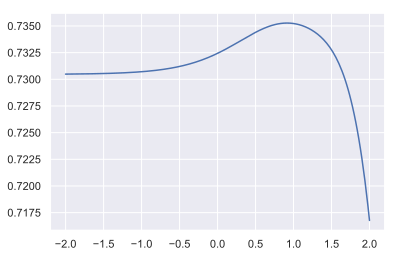

In [198]:
#Create a list of alphaas to itrate over and find best alpha for Ridge and Lasso
alphalist = 10**(np.linspace(-2,2,200))
ridge_r2 = []

for i, alpha_i in enumerate(alphalist):
    #x is already standardized 
    temp_ridge = Ridge(alpha=alpha_i)
    ridge_r2.append(np.mean(cross_val_score(temp_ridge, X_train2_scaled, y_train2, 
                                                      cv=kf, scoring='r2')))

#plot the r^2s
plt.plot(np.log10(alphalist), ridge_r2)

## This is the value of alpha that gave us the highest r^2
best_4_ridge = alphalist[np.argmax(ridge_r2)]
print(alphalist[np.argmax(ridge_r2)])

4.297004704320839


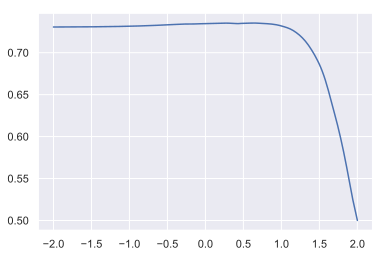

In [199]:
alphalist = 10**(np.linspace(-2,2,200))
lasso_r2 = []

for i, alpha_i in enumerate(alphalist):
    temp_lasso = Lasso(alpha=alpha_i)
    lasso_r2.append(np.mean(cross_val_score(temp_lasso, X_train2_scaled, y_train2, 
                                                      cv=kf, scoring='r2')))
#plot the r^2s
plt.plot(np.log10(alphalist), lasso_r2)

## This is the value of alpha that gave us the highest r^2
best_4_lasso = alphalist[np.argmax(lasso_r2)] #
print(alphalist[np.argmax(lasso_r2)])

In [201]:
#Linear Regression again
#linreg_cv2 = LinearRegression() 
#print("Mean R^2 for Normal Linear CV Regression", np.mean(cross_val_score(linreg_cv2, X_train2, y_train2, cv=kf, scoring='r2')))
#print("\n")

#Best alpha Ridge model
ridge_cv2 = Ridge(alpha=best_4_ridge)
print("Mean R^2 for Ridge CV Regression w/ best alpha", np.mean(cross_val_score(ridge_cv2, X_train2_scaled, y_train2, cv=kf, scoring='r2')))
print("\n")

#Best alpha Lasso model
lasso_cv2 = Lasso(alpha=best_4_lasso)
print("Mean R^2 for Lasso CV Regression w/ best alpha", np.mean(cross_val_score(lasso_cv2, X_train2_scaled, y_train2, cv=kf, scoring='r2')))

Mean R^2 for Normal Linear CV Regression 0.7304618514524198


Mean R^2 for Ridge CV Regression w/ best alpha 0.7352754274125463


Mean R^2 for Lasso CV Regression w/ best alpha 0.7352996400140185


### Lasso Regression seems to performing the best, lets look at it a bit closer now

In [202]:
#Poly just to check if it makes a difference
poly_reg = PolynomialFeatures(degree=2)
X_train2_poly = poly_reg.fit_transform(X_train2.values)
X_val_poly = poly_reg.fit_transform(X_val.values)

#scaling after applying polynomial....
scaler2 = StandardScaler()
X_train2_poly_scaled = scaler2.fit_transform(X_train2)
X_val_poly_scaled = scaler2.transform(X_val)
X_test_poly_scaled = scaler2.transform(X_test)


/Users/danielobennett/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/danielobennett/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/danielobennett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/Users/danielobennett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


In [203]:
#Ridge poly regression 
ridge_cv3 = Ridge()
print("Mean R^2 for Poly Ridge CV Regression w/ best alpha", np.mean(cross_val_score(ridge_cv3, X_train2_poly_scaled, y_train2, cv=kf, scoring='r2')))
print("\n")

lasso_cv3 = Lasso()
print("Mean R^2 for Poly Lasso CV Regression w/ best alpha", np.mean(cross_val_score(lasso_cv3, X_train2_poly_scaled, y_train2, cv=kf, scoring='r2')))


ERROR
Mean R^2 for Normal Linear CV Regression -11512208482289.438


Mean R^2 for Poly Ridge CV Regression w/ best alpha 0.7324368651161421


Mean R^2 for Poly Lasso CV Regression w/ best alpha 0.7347593317216967


In [204]:
#poly Ridge Regression scaled with best alpha
print("CV scaled poly with best alpha")
ridge_cv4 = Ridge(best_4_ridge)
print("Mean R^2 for Poly Ridge CV Regression w/ best alpha", np.mean(cross_val_score(ridge_cv4, X_train2_poly_scaled, y_train2, cv=kf, scoring='r2')))

#poly Lasso Regression scaled with best alpha
lasso_cv4 = Lasso(alpha=best_4_lasso)
print("Mean R^2 for Poly Lasso CV Regression w/ best alpha", np.mean(cross_val_score(lasso_cv4, X_train2_poly_scaled, y_train2, cv=kf, scoring='r2')))

CV scaled poly with best alpha
Mean R^2 for Poly Ridge CV Regression w/ best alpha 0.7352754274125463
Mean R^2 for Poly Lasso CV Regression w/ best alpha 0.7352996400140185


### Lets run the best Model on the test data: 
Final Model Time: Lasso Regression with the "best" alpha and scaled data

In [205]:
final_lasso = Lasso(best_4_lasso)

final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train)
X_test_scaled = final_scaler.transform(X_test)

final_lasso.fit(X_train_scaled, y_train)
print("Final Model Training score", final_lasso.score(X_train_scaled,y_train))
print("Final Model Test Score", final_lasso.score(X_test_scaled, y_test))
print("\n")
for feature, coef in zip(X.columns, final_lasso.coef_): 
    print(feature, ':', f'{coef:.2f}') 

Final Model Training score 0.7660645509446634
Final Model Test Score 0.6070599171486899


Bathroom : 30.05
Bedrooms : 462.44
Elevation : 67.30
Landmarks : -0.00
Pets Allowed? : 2.89
Starbucks_dist : -149.58
Tree_Cover_Pct : 31.43
Amenities_num : 170.35
Bay Ridge : -40.61
Bedford Stuyvesant : 77.86
Bensonhurst : -54.64
Bergen Beach : -5.77
Boerum Hill : 185.91
Borough Park : -0.79
Brighton Beach : -12.57
Brooklyn Heights : 116.89
Brownsville : 18.47
Bushwick : 0.00
Canarsie : 0.00
Carroll Gardens : 105.50
Clinton Hill : 50.14
Cobble Hill : 161.17
Coney Island : 3.08
Crown Heights : 6.18
DUMBO : 37.44
Downtown : 32.33
Dyker Heights : -19.34
East Flatbush : 0.00
East New York : -25.88
Flatbush : -19.47
Fort Greene : 106.63
Fort Hamilton : -28.43
Georgetown : -4.07
Gowanus : 30.92
Gravesend : -34.97
Greenpoint : 98.23
Greenwood : 18.37
Homecrest : -14.17
Kensington : 5.02
Marine Park : -17.69
Midwood : -33.24
Mill Basin : 0.00
New Utrecht : -31.74
Ocean Hill : 0.00
Ocean Parkway : 0.00
Par

/Users/danielobennett/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/danielobennett/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/danielobennett/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


(238,) [238   1]
RMSE 554.8737446352741
MAE 325.3492314503554
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


Text(0, 0.5, 'Residuals')

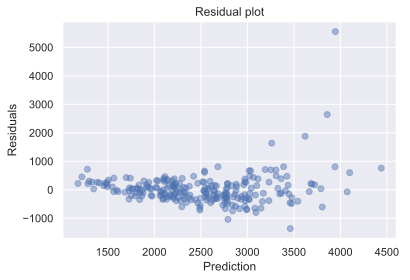

In [241]:
###plot residuals
predicted = final_lasso.predict(X_test_scaled)

print(predicted.shape, np.array(y_test.shape))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print("MAE", metrics.mean_absolute_error(y_test, predicted))
y_test
res = y_test['Rent'] - predicted

plt.scatter(predicted, res, alpha=.45)
plt.title("Residual plot")
plt.xlabel("Prediction")
plt.ylabel("Residuals")

In [242]:
print(df['Rent'].mean())

2508.890756302521
